In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import multiprocessing as mp
import scipy.optimize as opt
import scipy.stats as stats
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

In [3]:
kw = dict(columns=['q2','q4'])

with pd.HDFStore('/home/matt/Dropbox/data/nonextensive/data.h5') as store:
    
    data = {'complete': store.select('complete', **kw), 
            'diluted': store.select('diluted', **kw).reset_index('z', drop=True)}
    
    data = pd.concat(data, names=['model'])

In [4]:
data['chi_s'] = data.eval('L**(2/3)*q2')

In [53]:
data.head()

q2        q4     chi_s
model    sigma L  T   sample                              
complete 0     64 0.5 0       0.345687  0.173157  5.530992
                      1       0.497809  0.294160  7.964939
                      2       0.294169  0.125569  4.706706
                      3       0.308260  0.142238  4.932166
                      4       0.185168  0.076925  2.962686

In [54]:
groups = data.groupby(level=['model','sigma','L','T'])

In [55]:
def binderG(df):
    n = len(df)
    xj = (df.sum() - df) / (n - 1.)
    gj = xj.eval('0.5*(3. - q4/q2**2)')
    return pd.Series({'mean': gj.mean(), 'sem': sqrt(n-1) * gj.std()})

In [56]:
df = {'G': groups.apply(binderG),
      'chi_s': groups['chi_s'].agg(['mean','sem'])}

df = pd.concat(df, names=['meas'])

In [57]:
df.head()

mean       sem
meas model    sigma L  T                        
G    complete 0     64 0.500  0.756574  0.001338
                       0.525  0.737986  0.001381
                       0.550  0.718358  0.001422
                       0.575  0.697232  0.001464
                       0.600  0.674997  0.001502

In [58]:
def find_crossing(y1, y2, a, b, **kw):
    
    T1, T2 = (y.index.get_level_values('T') for y in (y1, y2))
    
    f1, f2 = (UnivariateSpline(T, y['mean'], w=1/y['sem'], **kw)
              for T, y in ((T1, y1), (T2, y2)))
    
    a = max(a, max(T1[0],  T2[0]))
    b = min(b, min(T1[-1], T2[-1]))
    
    Tx = opt.bisect(lambda T: f1(T) - f2(T), a, b)
    return Tx

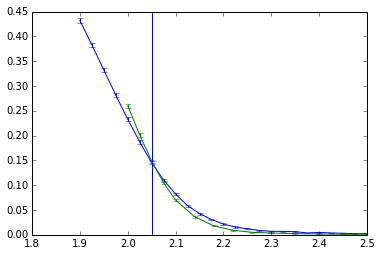

In [59]:
y1 = df.loc['G','diluted',0,8192]
y2 = df.loc['G','diluted',0,16384]
errorbar(y1.index, y1['mean'], y1['sem'])
errorbar(y2.index, y2['mean'], y2['sem'])
Tx = find_crossing(y1, y2, 1.9, 2.2)
axvline(Tx)

In [60]:
def find_crossings(y, a, b, **kw):
    sizes = y.index.get_level_values('L').unique()
    Tx = {}

    for L1, L2 in zip(sizes[:-1], sizes[1:]):
        try:
            Tx[L1] = find_crossing(y.xs(L1, level='L'), 
                                   y.xs(L2, level='L'), 
                                   a, b, **kw)
        except ValueError:
            print('problem finding crossing for L={},{}'.format(L1, L2))
            
    Tx = pd.Series(Tx)
    Tx.index.name = 'L'
    return Tx

In [61]:
df.loc['G','complete',0].head()

mean       sem
L  T                        
64 0.500  0.756574  0.001338
   0.525  0.737986  0.001381
   0.550  0.718358  0.001422
   0.575  0.697232  0.001464
   0.600  0.674997  0.001502

In [62]:
Tx = find_crossings(df.loc['G','complete',0], 0.8, 1.2)
Tx

L
64      0.877764
128     0.946242
256     0.954547
512     0.987051
1024    0.987071
2048    0.985424
dtype: float64

In [63]:
df.head()

mean       sem
meas model    sigma L  T                        
G    complete 0     64 0.500  0.756574  0.001338
                       0.525  0.737986  0.001381
                       0.550  0.718358  0.001422
                       0.575  0.697232  0.001464
                       0.600  0.674997  0.001502

In [64]:
def find_crossings_auto(df, bounds={'complete': (0.8, 1.1), 'diluted': (1.8, 2.2)}, **kw):
    '''Select appropriate temperature range for model.'''
    return pd.concat({model: find_crossings(y, *bounds[model], **kw) 
                      for model, y in df.groupby(level='model')},
                     names=['model'])

In [65]:
Tx = df.groupby(level=['meas','sigma']).apply(find_crossings_auto)
Tx.head()

meas  sigma  model     L   
G     0      complete  64      0.877764
                       128     0.946242
                       256     0.954547
                       512     0.987051
                       1024    0.987071
dtype: float64

In [66]:
data.head()

q2        q4     chi_s
model    sigma L  T   sample                              
complete 0     64 0.5 0       0.345687  0.173157  5.530992
                      1       0.497809  0.294160  7.964939
                      2       0.294169  0.125569  4.706706
                      3       0.308260  0.142238  4.932166
                      4       0.185168  0.076925  2.962686

In [73]:
def compute_crossings(data):
    
    groups = data.groupby(level=['model','sigma','L','T'], group_keys=False)
    
    df = {'G': groups.apply(binderG),
          'chi_s': groups['chi_s'].agg(['mean','sem'])}
    
    df = pd.concat(df, names=['meas'])
    Tx = df.groupby(level=['meas','sigma']).apply(lambda df: find_crossings_auto(df, s=0)) # XXX no smoothing
    Tx = Tx.unstack('meas')
    Tx.columns = ['Tx_G', 'Tx_chi']
    
    return Tx

In [74]:
time compute_crossings(data).head()

CPU times: user 14.3 s, sys: 810 ms, total: 15.1 s
Wall time: 14.3 s


Tx_G    Tx_chi
sigma model    L                       
0     complete 64    0.880627  0.985819
               128   0.946485  0.994533
               256   0.958188  0.994511
               512   0.985595  0.998724
               1024  0.986326  0.995093

In [75]:
def bootstrap_sample(groups):
    return groups.apply(lambda x: x.take(random_integers(0, len(x)-1, len(x))))


class BootstrapSampler:
    
    def __init__(self, data, groupby, reducer):
        self.data = data
        self.groupby = groupby
        self.reducer = reducer
        
    def __call__(self, seed):
        random.seed(seed)
        resamp = bootstrap_sample(self.data.groupby(level=self.groupby, group_keys=False))
        return self.reducer(resamp)

In [76]:
seeds = random_integers(1e5, size=100)
bs = BootstrapSampler(data, ['model','sigma','L','T'], compute_crossings)

with mp.Pool(2) as p:
    samples = p.map(bs, seeds)

samples = pd.concat(samples, keys=seeds, names=['seed'])

In [77]:
samples.head()

Tx_G    Tx_chi
seed  sigma model    L                       
28933 0     complete 64    0.873538  0.982494
                     128   0.948951  0.996199
                     256   0.953803  0.993128
                     512   0.985526  0.997068
                     1024  0.986405  0.993146

In [ ]:
#samples.to_hdf('Tx-samples.h5', 'samples')

In [ ]:
#samples.to_hdf('Tx-samples-2.h5', 'samples')

In [26]:
#samples.to_hdf('Tx-samples-3.h5', 'samples')

In [78]:
samples.to_hdf('Tx-samples-nosmooth.h5', 'samples')

# checkpoint

In [5]:
samples = pd.read_hdf('Tx-samples-nosmooth.h5', 'samples')

In [6]:
Tx = samples.groupby(level=['model','sigma','L']).agg(['mean','std'])

In [7]:
Tx.head()

Tx_G              Tx_chi          
                         mean       std      mean       std
model    sigma L                                           
complete 0     64    0.879893  0.005873  0.986185  0.003413
               128   0.946831  0.005038  0.994559  0.003048
               256   0.958142  0.003627  0.994716  0.002196
               512   0.985108  0.003531  0.998816  0.002224
               1024  0.985846  0.004472  0.994625  0.002401

In [8]:
Tx_flatcols = Tx.copy()
Tx_flatcols.columns = ['_'.join(t) for t in Tx.columns.values]

In [9]:
Tx_flatcols.head()

Tx_G_mean  Tx_G_std  Tx_chi_mean  Tx_chi_std
model    sigma L                                                 
complete 0     64     0.879893  0.005873     0.986185    0.003413
               128    0.946831  0.005038     0.994559    0.003048
               256    0.958142  0.003627     0.994716    0.002196
               512    0.985108  0.003531     0.998816    0.002224
               1024   0.985846  0.004472     0.994625    0.002401

In [10]:
for (sigma, model), df in Tx_flatcols.groupby(level=['sigma','model']):
    fmt = dict(mod=('c' if model == 'complete' else 'd'),
               sig='{:.1f}'.format(10*sigma).replace('.',''))
    df.to_csv('../data/Tx-{mod}-s{sig}.csv'.format(**fmt))

$$T^*(L,2L) = T_c - A/L^{2/3}$$

In [11]:
def fit_Tc(df, s=0, makeplot=True, color='b'):
    
    L = df.index.values
    x = L**(-2/3.)
    y = df['mean']
    yerr = df['std']
    
    xf, yf, yerrf = (a[s:] for a in (x, y, yerr))
    #p, cov = polyfit(xf, yf, w=1./yerrf, deg=1, cov=True)
    f = lambda x, a, b: a*x + b
    p, cov = curve_fit(f, xf, yf, [2, 1], sigma=yerrf)
    
    perr = sqrt(diag(cov))
    resids = (polyval(p, xf) - yf)/yerrf
    chi2 = sum(resids**2)
    ndf = len(xf) - len(p)
    Q = 1. - stats.chi2.cdf(chi2, ndf)
    
    if makeplot:
        errorbar(x, y, yerr, color=color, marker='.', ls='')
        plot(xlim(), polyval(p, xlim()), color=color)
        
    return pd.Series({'A':  p[0], 'A_err':  perr[0],
                      'Tc': p[1], 'Tc_err': perr[1],
                      'Q': Q}) 

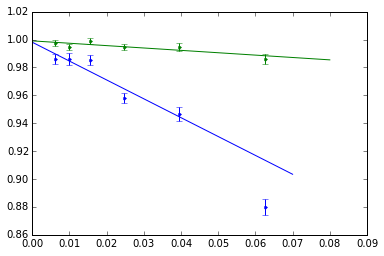

In [12]:
fits = pd.concat({'G':   fit_Tc(Tx.Tx_G.loc['complete',0], s=1),
                  'chi': fit_Tc(Tx.Tx_chi.loc['complete',0], color='g')})

In [13]:
fits

G    A        -1.352330
     A_err     0.296350
     Q         0.020701
     Tc        0.998060
     Tc_err    0.005994
chi  A        -0.170231
     A_err     0.058388
     Q         0.481516
     Tc        0.999023
     Tc_err    0.001578
dtype: float64

In [14]:
fits.index.names = ['quantity','fit_param']
df = fits.unstack()[['Tc','Tc_err','A','A_err','Q']]

In [15]:
df

fit_param,Tc,Tc_err,A,A_err,Q
quantity,,,,,
G,0.998060,0.005994,-1.352330,0.296350,0.020701
chi,0.999023,0.001578,-0.170231,0.058388,0.481516


In [16]:
df.to_csv('Tx-extrap-c-s00.fit.csv')

In [17]:
!head Tx-extrap-c-s00.fit.csv

quantity,Tc,Tc_err,A,A_err,Q
G,0.9980602037045974,0.005993777223386575,-1.3523295868194607,0.2963500596827892,0.020701225716146965
chi,0.9990228023406562,0.0015784065255863855,-0.17023139493317963,0.05838816055992074,0.4815163054689263


In [21]:
def write_fit_file(sigma=0, model='complete'):

    sigma_label = round(100*sigma)
    
    df = Tx.xs([model, sigma], level=['model','sigma'])

    fits = pd.concat({'G':   fit_Tc(df.Tx_G, s=1, makeplot=False),
                      'chi': fit_Tc(df.Tx_chi, makeplot=False)})
    
    print(fits.loc[:,'Q'])

    fits.index.names = ['quantity','fit_param']
    df = fits.unstack()[['Tc','Tc_err','A','A_err','Q']]
    df.to_csv('../fits/Tx-{}-s{:02d}.fit.csv'.format(model[0], sigma_label))

In [22]:
for t in [(0,'complete'),(0.25,'complete'),(0,'diluted'),(0.25,'diluted'),(0.375,'diluted')]:
    write_fit_file(*t)

G      0.020701
chi    0.481516
dtype: float64
G      0.294852
chi    0.730031
dtype: float64
G      0.222495
chi    0.153509
dtype: float64
G      0.264838
chi    0.273664
dtype: float64
G      0.584967
chi    0.578442
dtype: float64
